In [1]:
import pandas as pd
import numpy as np
from matplotlib.animation import FuncAnimation
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend

sns.set_theme(style="whitegrid")

In [3]:
# EIP4844 configuration
MAX_BLOB_GAS_PER_BLOCK = 786432
TARGET_BLOB_GAS_PER_BLOCK = 393216
MIN_BASE_FEE_PER_BLOB_GAS_4844 = 1
BLOB_BASE_FEE_UPDATE_FRACTION = 3338477
GAS_PER_BLOB = 2**17

# EIP7762 configuration
MIN_BASE_FEE_PER_BLOB_GAS = 2 ** 25

# simuplation configuration
TIMESTEMPS = 5 * 60 * 24 * 2
RUNS = 200

In [4]:
# EIP-4844 Pricing Formula

def fake_exponential(factor: int, numerator: int, denominator: int) -> int:
    i = 1
    output = 0
    numerator_accum = factor * denominator
    while numerator_accum > 0:
        output += numerator_accum
        numerator_accum = (numerator_accum * numerator) // (denominator * i)
        i += 1
    return output // denominator

def fake_exponential_bn(factor: int, numerator: int, denominator: int) -> int:
    _factor = np.int64(factor)
    _numerator = np.int64(numerator)
    _denominator = np.int64(denominator)
    i = np.int64(1)
    _output = np.int64(0)
    _numerator_accum = _factor * _denominator
    while _numerator_accum > 0:
        _output = np.add(_output, _numerator_accum, dtype=object)
        _numerator_accum = np.floor_divide(np.multiply(_numerator_accum, _numerator, dtype=object), np.multiply(_denominator, i, dtype=object), dtype=object)
        i += 1
    return np.floor_divide(_output, _denominator, dtype=object)

def calc_excess_blob_gas(target_blob_gas_per_block: int, parent_excess_blob_gas: int, parent_blob_gas_used: int) -> int:
    if parent_excess_blob_gas + parent_blob_gas_used < target_blob_gas_per_block:
        return 0
    else:
        return parent_excess_blob_gas + parent_blob_gas_used - target_blob_gas_per_block

def get_base_fee_per_blob_gas(min_base_fee_per_blob_gas: int, excess_blob_gas: int, blob_base_fee_update_fraction: int) -> int:
    return fake_exponential(
        min_base_fee_per_blob_gas,
        excess_blob_gas,
        blob_base_fee_update_fraction
    )

In [5]:
# EIP-4844 Blob Fee Market Model

def policy_resource_fee(params, substep, state_history, previous_state):
    target_blob_gas_per_block = params['target_blob_gas_per_block']

    parent_blob_gas_used = previous_state['blob_gas_used']
    parent_excess_blob_gas = previous_state['excess_blob_gas']

    excess_blob_gas = calc_excess_blob_gas(target_blob_gas_per_block, parent_excess_blob_gas, parent_blob_gas_used)

    return {
        'excess_blob_gas': excess_blob_gas
    }

def policy_resource_usage(params, substep, state_history, previous_state):
    process_blob_gas_used = params['process_blob_gas_used']
    
    run = previous_state['run']
    timestep = previous_state['timestep']

    blob_gas_used = process_blob_gas_used(run, timestep)

    return {
        'blob_gas_used': blob_gas_used
    }

def update_excess_blob_gas(params, substep, state_history, previous_state, policy_input):
    excess_blob_gas = policy_input['excess_blob_gas']
    return ('excess_blob_gas', excess_blob_gas)

def update_blob_gas_used(params, substep, state_history, previous_state, policy_input):
    blob_gas_used = policy_input['blob_gas_used']
    return ('blob_gas_used', blob_gas_used)

initial_state = {
    'blob_gas_used': 0,
    'excess_blob_gas': 0,
}

state_update_blocks = [
    {
        'policies': {
            'resource_fee': policy_resource_fee,
        },
        'variables': {
            'excess_blob_gas': update_excess_blob_gas,
        }
    },
    {
        'policies': {
            'resource_usage': policy_resource_usage,
        },
        'variables': {
            'blob_gas_used': update_blob_gas_used,
        }
    },
]

In [6]:
# Demand Sampling

rng = np.random.default_rng()

def truncated_poisson(lam: int, max_value: int, size: int):
    temp_size = size
    while True:
        temp_size *= 2
        temp = rng.poisson(lam=lam, size=temp_size)
        truncated = temp[temp <= max_value]
        if len(truncated) >= size:
            return truncated[:size]
    
def generate_poisson_demand(lam: int):
    return [truncated_poisson(lam=lam, max_value=6, size=TIMESTEMPS + 1) * GAS_PER_BLOB for run in range(RUNS)]

def generate_uniform_demand():
    return rng.integers(low=0, high=6, size=(RUNS, TIMESTEMPS + 1), endpoint=True) * GAS_PER_BLOB

def generate_bimodal_demand():
    return rng.choice(a=[0, 1, 2, 3, 4, 5, 6], p=[0.5, 0, 0, 0, 0, 0, 0.5], size=(RUNS, TIMESTEMPS + 1)) * GAS_PER_BLOB

In [7]:
cases = [
    {
        'name': 'The blob demand follows a Poisson distribution with lambda = 1',
        'samples': generate_poisson_demand(1)
    },
    {
        'name': 'The blob demand follows a Poisson distribution with lambda = 5',
        'samples': generate_poisson_demand(5)
    },
    {
        'name': 'The blob demand follows a Poisson distribution with lambda = 3',
        'samples': generate_poisson_demand(3)
    },
    {
        'name': 'The blob demand follows an uniform distribution',
        'samples': generate_uniform_demand()
    },
    {
        'name': 'The blob demand follows a bimodal distribution with peaks = 0, 6',
        'samples': generate_bimodal_demand()
    },
]

In [8]:
def create_simulation(case):
    model = Model(
        initial_state=initial_state,
        state_update_blocks=state_update_blocks,
        params={
            'target_blob_gas_per_block': [TARGET_BLOB_GAS_PER_BLOCK],
            'process_blob_gas_used': [lambda run, timestep: case['samples'][run - 1][timestep]],
        },
    )
    simulation = Simulation(
        model=model,
        timesteps=TIMESTEMPS,
        runs=RUNS
    )
    return simulation

simulations = list(map(create_simulation, cases))
experiment = Experiment(simulations=simulations)
experiment.engine = Engine(backend=Backend.PATHOS, drop_substeps=True)
result = experiment.run()

python(3767) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3768) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3769) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3770) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3771) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3772) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3773) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3774) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3775) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(3776) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [9]:
df = pd.DataFrame(result)
df

,blob_gas_used,excess_blob_gas,simulation,subset,run,substep,timestep
0,0,0,0,0,1,0,0
1,131072,0,0,0,1,2,1
2,262144,0,0,0,1,2,2
3,131072,0,0,0,1,2,3
4,262144,0,0,0,1,2,4
...,...,...,...,...,...,...,...
14400995,786432,24772608,4,0,200,2,14396
14400996,786432,25165824,4,0,200,2,14397
14400997,0,25559040,4,0,200,2,14398
14400998,786432,25165824,4,0,200,2,14399


In [10]:
df_excess_blob_gas_stats = df.groupby(['simulation', 'timestep'])['excess_blob_gas'].describe()
df_excess_blob_gas_stats["base_fee_per_blob_gas"] = df_excess_blob_gas_stats["mean"].apply(lambda value: get_base_fee_per_blob_gas(MIN_BASE_FEE_PER_BLOB_GAS, value, BLOB_BASE_FEE_UPDATE_FRACTION))
df_excess_blob_gas_stats


count         mean           std       min         25%  \
simulation timestep                                                           
0          0         200.0         0.00  0.000000e+00       0.0         0.0   
           1         200.0         0.00  0.000000e+00       0.0         0.0   
           2         200.0      2621.44  2.260707e+04       0.0         0.0   
           3         200.0      2621.44  2.260707e+04       0.0         0.0   
           4         200.0      5242.88  2.890820e+04       0.0         0.0   
...                    ...          ...           ...       ...         ...   
4          14396     200.0  38647234.56  2.970103e+07       0.0  14942208.0   
           14397     200.0  38655098.88  2.964403e+07       0.0  14942208.0   
           14398     200.0  38649200.64  2.963342e+07       0.0  15335424.0   
           14399     200.0  38641336.32  2.965489e+07  393216.0  14942208.0   
           14400     200.0  38609879.04  2.963989e+07  786432.0  14548992.0   

                            50%         75%          max  \
simulation timestep                                        
0          0                0.0         0.0          0.0   
           1                0.0         0.0          0.0   
           2                0.0         0.0     262144.0   
           3                0.0         0.0     262144.0   
           4                0.0         0.0     262144.0   
...                         ...         ...          ...   
4          14396     30277632.0  56229888.0  140771328.0   
           14397     29884416.0  56328192.0  140378112.0   
           14398     30277632.0  56328192.0  140771328.0   
           14399     29884416.0  56131584.0  140378112.0   
           14400     30277632.0  56426496.0  139984896.0   

                     base_fee_per_blob_gas  
simulation timestep                         
0          0                  3.355443e+07  
           1                  3.355443e+07  
           2                  3.358079e+07  
           3                  3.358079e+07  
           4                  3.360717e+07  
...                                    ...  
4          14396              3.575001e+12  
           14397              3.583432e+12  
           14398              3.577107e+12  
           14399              3.568690e+12  
           14400              3.535222e+12  

[72005 rows x 9 columns]

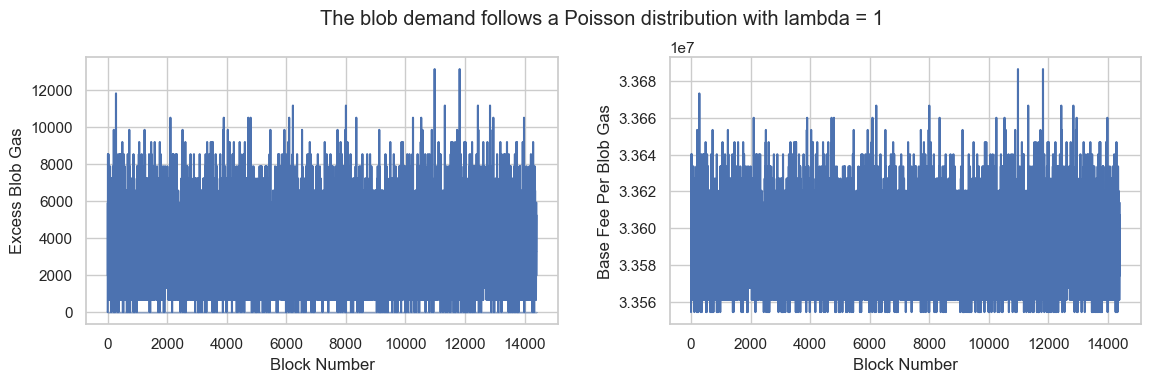

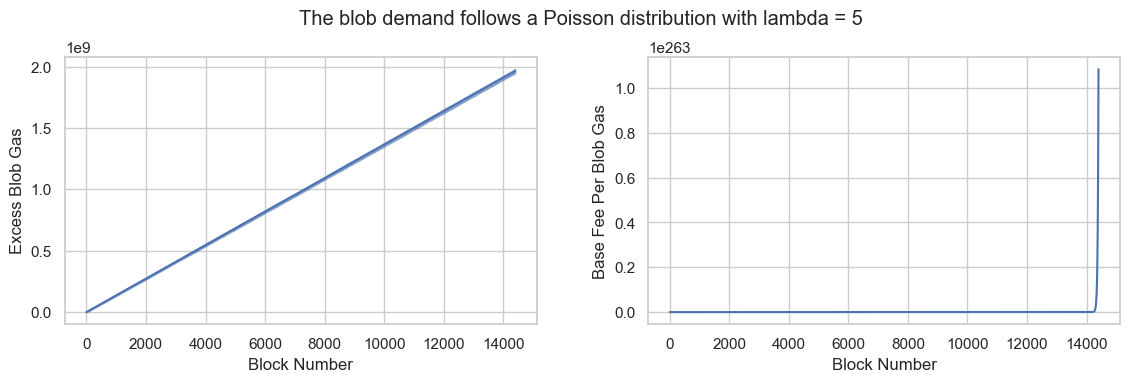

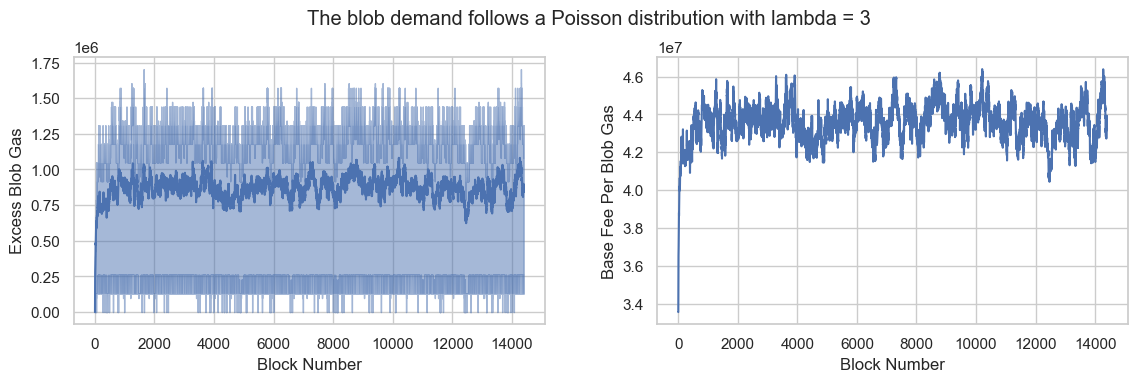

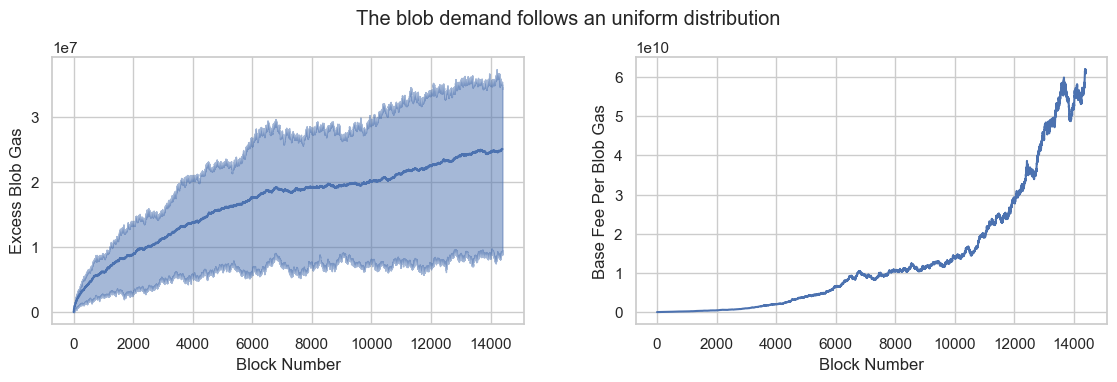

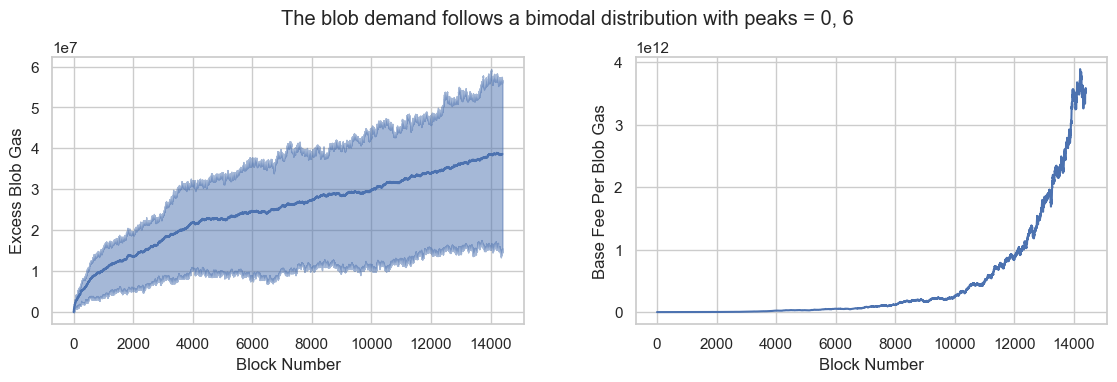

In [12]:
for index, case in enumerate(cases):
    excess_blob_gas = df_excess_blob_gas_stats.loc[index]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.tight_layout(pad=3, w_pad=4, h_pad=3)
    fig.suptitle(case['name'])

    ax1.plot(excess_blob_gas.index, excess_blob_gas['mean'].values, label='Mean')
    ax1.fill_between(excess_blob_gas.index, excess_blob_gas['25%'].values, excess_blob_gas['75%'].values, color='b', alpha=0.5)
    ax1.set_xlabel('Block Number')
    ax1.set_ylabel('Excess Blob Gas')

    ax2.plot(excess_blob_gas.index, excess_blob_gas['base_fee_per_blob_gas'].values, label='Mean')
    ax2.set_xlabel('Block Number')
    ax2.set_ylabel('Base Fee Per Blob Gas')

    fig.savefig(f'img/eip7762-t{TIMESTEMPS}-r{RUNS}-c{index + 1}.png')


## Find the stable condition of the blob demand

In [18]:
demand_values = np.arange(3, 3.5, 0.05).round(2)

def create_simulation(demand_value: int):
    samples = generate_poisson_demand(demand_value)
    model = Model(
        initial_state=initial_state,
        state_update_blocks=state_update_blocks,
        params={
            'target_blob_gas_per_block': [TARGET_BLOB_GAS_PER_BLOCK],
            'process_blob_gas_used': [lambda run, timestep: samples[run - 1][timestep]],
        },
    )
    simulation = Simulation(
        model=model,
        timesteps=TIMESTEMPS,
        runs=RUNS
    )
    return simulation

simulations_sc = list(map(create_simulation, demand_values))
experiment_sc = Experiment(simulations=simulations_sc)
experiment_sc.engine = Engine(backend=Backend.PATHOS, drop_substeps=True)
result_sc = experiment_sc.run()

In [19]:
df_sc = pd.DataFrame(result_sc)
df_sc

,blob_gas_used,excess_blob_gas,simulation,subset,run,substep,timestep
0,0,0,0,0,1,0,0
1,524288,0,0,0,1,2,1
2,131072,131072,0,0,1,2,2
3,131072,0,0,0,1,2,3
4,393216,0,0,0,1,2,4
...,...,...,...,...,...,...,...
2880195,262144,312344576,9,0,20,2,14396
2880196,524288,312213504,9,0,20,2,14397
2880197,262144,312344576,9,0,20,2,14398
2880198,524288,312213504,9,0,20,2,14399


In [20]:
df_stats_sc = df_sc.groupby(['simulation', 'timestep'])['excess_blob_gas'].describe()
df_stats_sc['base_fee_per_blob_gas'] = df_stats_sc['mean'].apply(lambda value: get_base_fee_per_blob_gas(MIN_BASE_FEE_PER_BLOB_GAS, value, BLOB_BASE_FEE_UPDATE_FRACTION))
df_stats_sc

count         mean           std          min  \
simulation timestep                                                  
0          0          20.0          0.0  0.000000e+00          0.0   
           1          20.0          0.0  0.000000e+00          0.0   
           2          20.0      98304.0  1.193365e+05          0.0   
           3          20.0      98304.0  1.584034e+05          0.0   
           4          20.0     216268.8  2.220908e+05          0.0   
...                    ...          ...           ...          ...   
9          14396      20.0  336940236.8  2.718939e+07  267649024.0   
           14397      20.0  336914022.4  2.713357e+07  267911168.0   
           14398      20.0  336894361.6  2.711155e+07  267649024.0   
           14399      20.0  336809164.8  2.710332e+07  267517952.0   
           14400      20.0  336828825.6  2.713571e+07  267255808.0   

                             25%          50%          75%          max  \
simulation timestep                                                       
0          0                 0.0          0.0          0.0          0.0   
           1                 0.0          0.0          0.0          0.0   
           2                 0.0      65536.0     131072.0     393216.0   
           3                 0.0          0.0     163840.0     524288.0   
           4                 0.0     131072.0     327680.0     655360.0   
...                          ...          ...          ...          ...   
9          14396     320733184.0  340000768.0  359301120.0  372244480.0   
           14397     320897024.0  340131840.0  359301120.0  371851264.0   
           14398     320831488.0  340197376.0  359038976.0  371851264.0   
           14399     320634880.0  340262912.0  358744064.0  371720192.0   
           14400     320569344.0  340197376.0  358580224.0  371982336.0   

                     base_fee_per_blob_gas  
simulation timestep                         
0          0                  1.000000e+00  
           1                  1.000000e+00  
           2                  1.000000e+00  
           3                  1.000000e+00  
           4                  1.000000e+00  
...                                    ...  
9          14396              6.788110e+43  
           14397              6.735018e+43  
           14398              6.695471e+43  
           14399              6.526766e+43  
           14400              6.565317e+43  

[144010 rows x 9 columns]

In [21]:
stable_demand_range = [None, None]

for index, demand_value in enumerate(demand_values):
    stats = df_stats_sc.loc[index]
    tail_from = TIMESTEMPS - 7200
    tail_stats = stats['mean'][tail_from:]
    trend = tail_stats.diff().mean()
    if stable_demand_range[0] is None and tail_stats.mean() > GAS_PER_BLOB * 18:
        stable_demand_range[0] = demand_value
    if trend < 1000:
        stable_demand_range[1] = demand_value

stable_demand_range

[3.15, 3.2]

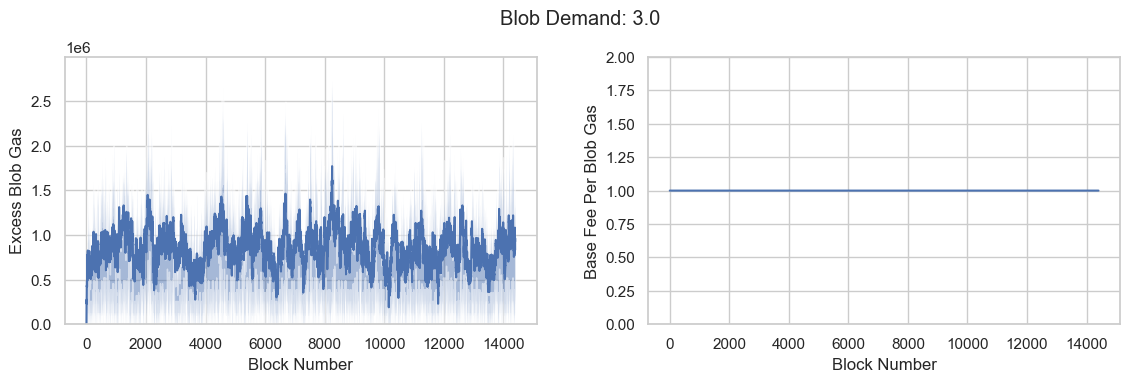

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout(pad=3, w_pad=4, h_pad=3)

ax1.set_xlabel('Block Number')
ax1.set_ylabel('Excess Blob Gas')
line1, = ax1.plot(range(TIMESTEMPS + 1), np.zeros(TIMESTEMPS + 1))
area1 = ax1.fill_between(range(TIMESTEMPS + 1), np.zeros(TIMESTEMPS + 1), np.zeros(TIMESTEMPS + 1), alpha=0.5)

ax2.set_xlabel('Block Number')
ax2.set_ylabel('Base Fee Per Blob Gas')
line2, = ax2.plot(range(TIMESTEMPS + 1), np.zeros(TIMESTEMPS + 1))

def updateFrame(frame: int):
    stats = df_stats_sc.loc[frame]
    fig.suptitle(f'Blob Demand: {demand_values[frame]}')
    ax1.set_ylim(top=stats['75%'].values.max() * 1.1, bottom=0)
    line1.set_ydata(stats['mean'].values)
    area1.set_data(stats.index, stats['25%'].values, stats['75%'].values)
    ax2.set_ylim(top=np.max([stats['base_fee_per_blob_gas'].max() * 1.1, 2]), bottom=0)
    line2.set_ydata(stats['base_fee_per_blob_gas'].values)

ani = FuncAnimation(fig, updateFrame, frames=range(len(demand_values)), interval=1000)
HTML(ani.to_jshtml())


### Prcing Curve

Text(0.5, 1.0, 'Pricing Formula comparison')

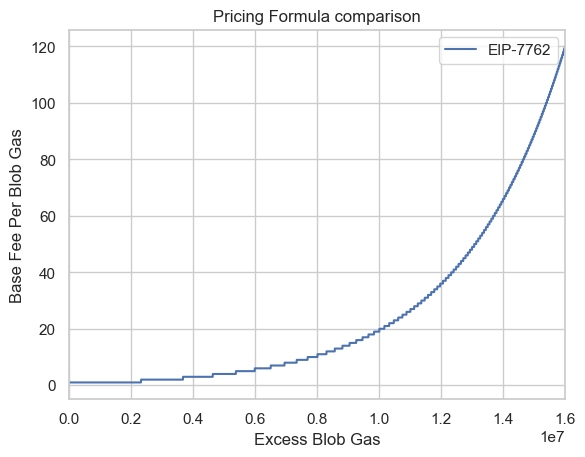

In [24]:
excess_blob_gas_values = np.arange(0, 16000000, dtype='int64')
# eip4844_pricing_values = np.array([get_base_fee_per_blob_gas(MIN_BASE_FEE_PER_BLOB_GAS_4844, gas, BLOB_BASE_FEE_UPDATE_FRACTION) for gas in excess_blob_gas_values])
eip7762_pricing_values = np.array([get_base_fee_per_blob_gas(MIN_BASE_FEE_PER_BLOB_GAS, gas, BLOB_BASE_FEE_UPDATE_FRACTION) for gas in excess_blob_gas_values])

fig_pricing_formula, axs_pricing_formula = plt.subplots()
# axs_pricing_formula.plot(excess_blob_gas_values, eip4844_pricing_values, label="EIP-4844")
axs_pricing_formula.plot(excess_blob_gas_values, eip7762_pricing_values, label="EIP-7762")
axs_pricing_formula.legend(loc='best')
axs_pricing_formula.set_xlim(0, 16000000)
axs_pricing_formula.set_xlabel("Excess Blob Gas")
axs_pricing_formula.set_ylabel("Base Fee Per Blob Gas")
axs_pricing_formula.set_title("Pricing Formula comparison")